# rewrite loading xyz using ase

In [1]:

# -----------------------------------------------------------------------------
# :author:    Juanjuan Huang & Shelly D. Keylly
# :email:     juanjuan.huang@anl.gov
# :copyright: Copyright © 2023, UChicago Argonne, LLC
# -----------------------------------------------------------------------------


In [2]:
import py3Dmol
import numpy as np
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser
import ase
from ase.io import read
from ase.io import write
import plotly.graph_objects as go
from pprint import pprint
import ipywidgets as widgets
from IPython.display import display, clear_output
import os
from scipy.spatial.distance import pdist
from ase.neighborlist import NeighborList
from scipy.optimize import curve_fit
from collections import defaultdict

%matplotlib widget

def fit_polynomial(x, y, degree):
    """
    Fit a polynomial of the given degree to the provided points.
    
    Parameters:
    points (list of float): The points to fit the polynomial to.
    degree (int): The degree of the polynomial to fit.
    
    Returns:
    np.poly1d: The fitted polynomial.
    """
    # Fit the polynomial
    coeffs = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coeffs)
    
    # Create the polynomial equation as a string
    equation = "y = " + " + ".join([f"{coeff:.2f}x^{deg}" if deg > 0 else f"{coeff:.2f}" 
                                    for deg, coeff in enumerate(coeffs[::-1])])
    plt.figure()
    # Plot the points and the fitted polynomial
    plt.scatter(x, y, color='red', label='Data Points')
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = polynomial(x_fit)
    plt.plot(x_fit, y_fit, color='blue', label=f'Polynomial Fit (degree {degree})')
    # plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Polynomial Fit to Points')
    # Display the polynomial equation on the plot
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    
    plt.show()
    
    return polynomial

def fit_logarithmic(x, y):
    """
    Fit a logarithmic function to the provided points.
    
    Parameters:
    x (list of float): The x values of the points.
    y (list of float): The y values of the points.
    
    Returns:
    tuple: The parameters of the fitted logarithmic function.
    """
    # Define the logarithmic function
    def log_func(x, a, b, c):
        return a * np.log(b * x) + c

    # Fit the logarithmic function to the data
    popt, _ = curve_fit(log_func, x, y, maxfev=10000)

    # Create the logarithmic equation as a string
    a, b, c = popt
    equation = f"y = {a:.2f} * log({b:.2f} * x) + {c:.2f}"

    # Generate x values for plotting the fit
    x_fit = np.linspace(min(x), max(x), 100)
    # Generate y values using the fitted logarithmic function
    y_fit_log = log_func(x_fit, *popt)

    # Plot the data points and the logarithmic fit
    plt.figure()
    plt.scatter(x, y, color='red', label='Data Points')
    plt.plot(x_fit, y_fit_log, color='blue', label='Logarithmic Fit')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Logarithmic Fit to Points')
    # Display the logarithmic equation on the plot
    plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
    plt.show()

    return popt


class ButtonOutputManager:
    def __init__(self):
        self.fc = FileChooser()
        self.fc.register_callback(self.on_file_selected)
        self.output_file = widgets.Output()
        self.fc_box = widgets.HBox([self.fc, self.output_file])
        self.cluster_lst = {}
        
        self._button_layout = widgets.Layout(width='210px', height='25px')
        self._button_layout_narrow = widgets.Layout(width='170px', height='25px')
        self._box_layout = widgets.Layout(display='fixed', 
                                          align_items='center', 
                                          justify_content='flex-start',
                                          )


    def init_menu(self):
        self.output_show = widgets.Output()
        self.output_hist = widgets.Output()
        self.output_getCN = widgets.Output()
        
        self.button_show = widgets.Button(description="Show", layout=self._button_layout_narrow)
        self.button_hist = widgets.Button(description="Plot histogram", layout=self._button_layout_narrow)
        self.button_getCN = widgets.Button(description="Calculate CN", layout=self._button_layout)
        self.button_getCN_all = widgets.Button(description="Calculate all CN", layout=self._button_layout)

        self.add_menu_CN()
        self.add_menu_resize()
        self.add_menu_show()

        
        self.menu_box = widgets.HBox([self.box_menu_show,
                                      self.box_menu_CN,
                                      self.box_menu_resize,
                                     ])

        self.output_box = widgets.VBox([self.output_hist, 
                                        self.output_getCN])
        
        self.entire_box = widgets.HBox([self.menu_box, self.output_show])
        
    def update_menu(self):
        options_atoms = [(element, i) for i, element in enumerate(self.cluster.elements_num.keys())]
        self.dropdown_CN_center_atom.options = options_atoms
        self.dropdown_CN_neighbor_atom.options = options_atoms
        self.dropdown_CN_center_atom.value = 0
        self.dropdown_CN_neighbor_atom.value = 0
        self.content_text_shrink_radius.value = self.cluster.get_cluster_size()
        
        self.button_undo_changes.on_click(self.on_button_undo_changes_clicked)
        self.button_show.on_click(self.on_button_show_clicked)
        self.button_hist.on_click(self.on_button_hist_clicked)
        self.button_getCN.on_click(self.on_button_getCN_clicked)
        self.button_getCN_all.on_click(self.on_button_getCN_all_clicked)

        self.button_shrink.on_click(self.on_button_shrink_clicked)
        self.button_save.on_click(self.on_button_save_clicked)
        self.button_expand.on_click(self.on_button_expand_clicked)
        self.button_remove_atoms.on_click(self.on_button_remove_atoms_clicked)
        self.button_clear.on_click(self.on_button_clear_outpout)

    def add_menu_show(self):
        self.dropdown_view_checkbox_label = widgets.Checkbox(value=True,  description='Labels', disabled=False, layout=widgets.Layout(width='150px'))
        self.dropdown_view_checkbox_symbol = widgets.Checkbox(value=True,  description='Symbols', disabled=False, layout=widgets.Layout(width='160px'))

        # options_atoms = [(element, i) for i, element in enumerate(self.cluster.elements_num.keys())]
        # self.dropdown_view_highlight_atom1 = widgets.Dropdown(options=options_atoms, value=0, description='Red', layout=widgets.Layout(width='150px'))
        # self.dropdown_view_highlight_atom2 = widgets.Dropdown(options=options_atoms, value=0, description='Blue', layout=widgets.Layout(width='150px'))
        self.content_text_save = widgets.Text(value="", placeholder='File name', description='Save name', disabled=False, layout=widgets.Layout(width='160px'))        
        self.button_save = widgets.Button(description="Save to xyz", layout=self._button_layout_narrow)
        self.button_clear = widgets.Button(description="Clear output", layout=self._button_layout_narrow)

        self.box_menu_show = widgets.VBox([self.button_show,
                                           self.dropdown_view_checkbox_label,
                                           self.dropdown_view_checkbox_symbol,
                                           # self.dropdown_view_highlight_atom1,
                                           # self.dropdown_view_highlight_atom2,
                                           self.button_hist, 
                                           self.button_save,
                                           self.content_text_save,
                                           self.button_clear
                                           ])
        
    def add_menu_resize(self):
        self.button_shrink = widgets.Button(description="Shrink cluster", layout=self._button_layout)
        self.content_text_shrink_radius = widgets.FloatText(value=0, placeholder='Radius [A]', description='Radius [A]', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        self.content_text_shrink_center_atom = widgets.Text(value='', placeholder='e.g., 1', description='atom index', disabled=False, layout=widgets.Layout(width='160px'))

        self.button_expand = widgets.Button(description="Expand CIF", layout=self._button_layout)
        self.content_text_expand_factors_x = widgets.IntText(value=2, placeholder='x', description='x factor', disabled=False, step=1, layout=widgets.Layout(width='160px', align_items='stretch'))
        self.content_text_expand_factors_y = widgets.IntText(value=2, placeholder='y', description='y factor', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        self.content_text_expand_factors_z = widgets.IntText(value=2, placeholder='z', description='z factor', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        # self.content_text_expand_cif = widgets.FloatText(value=0, placeholder='Radius [A]', description='Radius [A]', disabled=False, step=1, layout=widgets.Layout(width='160px'))
        self.button_undo_changes = widgets.Button(description="Undo changes", layout=self._button_layout)
        self.button_remove_atoms = widgets.Button(description="Remove atoms", layout=self._button_layout)
        self.content_text_remove_atoms = widgets.Text(value='', placeholder='e.g. 1, 2, 3', description='atom indices', disabled=False, layout=widgets.Layout(width='160px', align_items='stretch'))
        
        self.box_menu_resize = widgets.VBox([self.button_shrink,
                                             self.content_text_shrink_radius,
                                             self.content_text_shrink_center_atom,
                                             self.button_expand,
                                             widgets.VBox([self.content_text_expand_factors_x, 
                                                           self.content_text_expand_factors_y, 
                                                           self.content_text_expand_factors_z], layout=widgets.Layout(width='100%', ajustify_content='flex-start')),
                                             self.button_remove_atoms,
                                             self.content_text_remove_atoms,
                                             self.button_undo_changes,
                                            ])
        
        
    def add_menu_CN(self):
        options = []
        self.dropdown_CN_center_atom = widgets.Dropdown(options=options, value=None, description='Center atom', layout=widgets.Layout(width='180px'))
        self.dropdown_CN_neighbor_atom = widgets.Dropdown(options=options, value=None, description='Neighbor atom', layout=widgets.Layout(width='180px'))
        self.content_text_CN_accuracy = widgets.FloatText(value=0.01, placeholder='Accuracy [A]', description='Accuracy [A]', disabled=False, step=0.01, layout=widgets.Layout(width='180px'))
        self.content_text_CN_range = widgets.FloatText(value=6, placeholder='Range [A]', description='Range [A]', disabled=False, step=1, layout=widgets.Layout(width='180px'))
        
        self.box_menu_CN = widgets.VBox([self.button_getCN, 
                                         self.dropdown_CN_center_atom,
                                         self.dropdown_CN_neighbor_atom,
                                         self.content_text_CN_accuracy,
                                         self.content_text_CN_range,
                                         self.button_getCN_all,
                                        ], layout=self._box_layout)
        
    def init_display(self):
        display(self.fc_box)
        self.init_menu()
        # display(self.menu_box)
        display(self.entire_box)
        display(self.output_box)

    def on_button_remove_atoms_clicked(self, b):
        remove_indices_str = self.content_text_remove_atoms.value
        try:
            remove_indices_lst = [int(i.strip()) for i in remove_indices_str.split(',')]
            # print("Processed list of integers:", remove_indices_lst)
            cluster_atoms_removed = self.cluster.remove_atoms(remove_indices_lst)
            self.cluster.load_xyz(from_file=False, atom_object=cluster_atoms_removed)
            self.on_button_show_clicked(b=None)
            self.content_text_shrink_radius.value = self.cluster.get_cluster_size()
        except Exception:
            with self.output_show:
                clear_output()
                print("Invalid input. Please enter a comma-separated list of numbers.")

    def on_button_show_clicked(self, b):
        with self.output_show:
            clear_output()
            self.cluster.view_xyz(#highlight_atom1=self.dropdown_view_highlight_atom1.label, 
                                  #highlight_atom2=self.dropdown_view_highlight_atom1.label, 
                                  label=self.dropdown_view_checkbox_label.value,
                                  show_symbol=self.dropdown_view_checkbox_symbol.value)
          
    def on_button_hist_clicked(self,b):
        with self.output_hist:
            clear_output()           
            if not hasattr(self, 'pairs_types'):
                self.cluster.get_pairs()
            
            plt.figure(figsize=(8,3))
            for key_i in self.cluster.pairs_group.keys():
                plt.hist(self.cluster.pairs_group[key_i]['distance'], bins=80, alpha=0.3, edgecolor='white', label=key_i)
            plt.xlabel("Distance [Å]")
            plt.ylabel("Number of pairs")
            plt.legend()
            plt.tight_layout()
            plt.show()
            
    def on_button_getCN_clicked(self, b):
        with self.output_getCN:
            clear_output()
            self.cluster.get_CN(center_atom=self.dropdown_CN_center_atom.label, 
                                CN_atom=self.dropdown_CN_neighbor_atom.label, 
                                error_bar=self.content_text_CN_accuracy.value, 
                                CN_range=self.content_text_CN_range.value, 
                                printit=True)
            
    def on_button_getCN_all_clicked(self, b):
        with self.output_getCN:
            clear_output()
            self.cluster.get_CN_all(error_bar=self.content_text_CN_accuracy.value, 
                                    CN_range=self.content_text_CN_range.value, 
                                    printit=True)
            
            
    def on_file_selected(self, chooser):
        with self.output_file:
            clear_output()
            print(f"File selected: {chooser.selected}")
            self.cluster = ClusterNeighbor()
            self.cluster.load_xyz(path=self.fc.value)
            self.update_menu()       

    def clear_output_windows(self):
        with self.output_show:
            clear_output()
        with self.output_hist:
            clear_output()
        with self.output_getCN:
            clear_output()  
    
    def on_button_clear_outpout(self, b):
         self.clear_output_windows()
         
    def on_button_undo_changes_clicked(self, b):
        self.cluster.load_xyz(path=self.fc.value)       
        # self.clear_output_windows()
        self.on_button_show_clicked(b=None)
        self.content_text_shrink_radius.value = self.cluster.get_cluster_size()

    
    def on_button_shrink_clicked(self, b):
        new_radius = self.content_text_shrink_radius.value        
        with self.output_getCN:
            clear_output()  
        with self.output_hist:
            clear_output()
            
        if new_radius < self.cluster.get_cluster_size():
            if self.content_text_shrink_center_atom.value == '':
                center_atom_index = None
            else:
                center_atom_index = int(self.content_text_shrink_center_atom.value)
            cluster_shrunk = self.cluster.shrink_cluster_size(new_radius=new_radius, center_atom_index=center_atom_index)
            self.cluster.load_xyz(from_file=False, atom_object=cluster_shrunk)
            # self.clear_output_windows()
            self.on_button_show_clicked(b=None)
        else:
            with self.output_show:
                clear_output()
                print("Should use a radius SMALLER than the current cluster size!")
    
    def on_button_expand_clicked(self, b):
        replication_factors = (self.content_text_expand_factors_x.value, 
                               self.content_text_expand_factors_y.value, 
                               self.content_text_expand_factors_z.value)
        try:
            cluster_expanded = self.cluster.expand_cif(replication_factors=replication_factors)
            self.cluster.load_xyz(from_file=False, atom_object=cluster_expanded)
            self.on_button_show_clicked(b=None)
            self.content_text_shrink_radius.value = self.cluster.get_cluster_size()
        except ValueError:
            with self.output_show:
                clear_output()
                print("it's NOT a CIF, cannot expand!")
        
    def on_button_save_clicked(self, b):
        self.cwd = os.path.dirname(self.fc.value)
        filename = os.path.join(self.cwd, self.content_text_save.value + '.xyz')
        print(f"save to {filename}")
        self.cluster.save(filename)

In [9]:
from collections import defaultdict
from ase.neighborlist import NeighborList
from ase import Atoms
import numpy as np

class ClusterNeighbor:
    def __init__(self):
        self.atoms = None
        self.elements = None
        self.elements_num = None
        self.element_index_group = None
        self.center = None
        self.xyz_string = ""
        self.pairs_index = []
        self.pairs_element = []
        self.pairs = []
        self.pairs_unique = []
        self.distance_all = []
        self.pairs_types = set()
        self.pairs_group = {}
        self.CN_distances = {}
        self.CN = {}
        self.cluster_size = 0

    def _calculate_distance(self, coord1, coord2):
        return np.linalg.norm(np.array(coord1) - np.array(coord2))

    def load_xyz(self, from_file=True, path=None, atom_object=None):
        if from_file:
            self.atoms = read(path)
        else:
            self.atoms = atom_object

        self.elements = [atom.symbol for atom in self.atoms]
        self.elements_num = {element: self.elements.count(element) for element in set(self.elements)}
        self.element_index_group = {element: [i for i, e in enumerate(self.elements) if e == element] for element in set(self.elements)}
        self.center = self.atoms.get_center_of_mass()
        
        self.xyz_string = f"{len(self.atoms)}\n\n" 
        for atom in self.atoms:
            self.xyz_string += f"{atom.symbol} {atom.position[0]} {atom.position[1]} {atom.position[2]}\n"

    def save(self, filename):
        write(filename, self.atoms)

    def expand_cif(self, replication_factors=(2, 2, 2), self_apply=False):
        expanded_cluster = self.atoms.repeat(replication_factors)
        if self_apply:
            self.atoms = expanded_cluster 
        return expanded_cluster

    def view_xyz(self, style_all=None, highlight_atom1="O", highlight_atom2="Pb", label=True, show_symbol=False):
        self.view = py3Dmol.view(width=400, height=400)
        self.view.addModel(self.xyz_string, 'xyz')
        if style_all is None:
            style_all = {'stick': {'radius': .1, 'alpha': 0.2, 'color': 'gray'}, 
                         'sphere': {'radius': .3}}
        self.view.setStyle(style_all)
        self.view.addStyle({'atom': highlight_atom1}, {'sphere': {'color': 'red', 'radius': 0.5}})
        self.view.addStyle({'atom': highlight_atom2}, {'sphere': {'color': 'blue', 'radius': 0.3}})
        self.view.setBackgroundColor('0xeeeeee')

        if label:
            for i, atom in enumerate(self.atoms):
                symbol = atom.symbol if show_symbol else ""
                self.view.addLabel(f"{i}{symbol}", {'position': {'x': atom.position[0], 'y': atom.position[1], 'z': atom.position[2]}, 
                                    'fontColor': 'k', 'fontSize': 12, 'backgroundColor': 'white', 'backgroundOpacity': 0.5})
        
        self.view.zoomTo()
        self.view.show()
        self.view.title(self.atoms.get_chemical_formula())

    def get_cluster_size(self):
        positions = self.atoms.get_positions()
        distances = pdist(positions)
        self.cluster_size = np.max(distances) / 2
        return self.cluster_size

    def shrink_cluster_size(self, new_radius=None, center_atom_index=None, self_apply=False):
        if new_radius is None:
            new_radius = self.cluster_size - 0.1
        center = self.atoms[center_atom_index].position if center_atom_index is not None else self.center
        distances = np.linalg.norm(self.atoms.positions - center, axis=1)
        mask = distances <= new_radius
        atoms_smaller = self.atoms[mask]
        if self_apply:
            self.atoms = atoms_smaller
        return atoms_smaller

    def remove_atoms(self, indices_remove_lst=[-1]):
        indices_keep_lst = [i for i in range(len(self.atoms)) if i not in indices_remove_lst]
        return self.atoms[indices_keep_lst]

    def get_pairs(self):
        num_atoms = len(self.atoms)
        pairs_index = np.array(np.triu_indices(num_atoms, k=1)).T
        pairs_element = np.array([[self.atoms[i].symbol, self.atoms[j].symbol] for i, j in pairs_index])
        pairs = np.array([f"{atom_i}-{atom_j}" for atom_i, atom_j in pairs_element])
        pairs_unique = np.array([f"{self.atoms[i].symbol}({i})-{self.atoms[j].symbol}({j})" for i, j in pairs_index])

        distance_matrix = self.atoms.get_all_distances()
        distance_all = distance_matrix[pairs_index[:, 0], pairs_index[:, 1]]

        pairs_types = set(pairs)
        self.pairs_index = pairs_index.tolist()
        self.pairs_element = pairs_element.tolist()
        self.pairs = pairs.tolist()
        self.pairs_unique = pairs_unique.tolist()
        self.distance_all = distance_all.tolist()
        self.pairs_types = pairs_types

        self.pairs_group = {
            key: {
                'pairs_index': pairs_index[np.array(self.pairs) == key].tolist(),
                'pairs_unique': pairs_unique[np.array(self.pairs) == key].tolist(),
                'distance': distance_all[np.array(self.pairs) == key].tolist()
            } for key in self.pairs_types
        }

        return self.pairs_group

    def get_CN(self, center_atom=None, CN_atom=None, error_bar=0.01, CN_range=5, printit=True):
        """
        Calculate the coordination number (CN) for a specified bond type in the atomic cluster.

        Parameters:
        center_atom (str): Symbol of the central atom type for which CN is calculated. Defaults to the first atom's symbol.
        CN_atom (str): Symbol of the neighboring atom type for which CN is calculated. Defaults to the second atom's symbol.
        error_bar (float): Threshold for identifying significant gaps in bond lengths. Defaults to 0.01.
        CN_range (float): Maximum distance to consider for coordination number calculations. Defaults to 5.
        printit (bool): Whether to print the results. Defaults to True.

        Returns:
        dict: A dictionary where the keys are bond lengths and the values are the calculated coordination numbers.

        Example:
        --------
        >>> cluster_neighbor = ClusterNeighbor()
        >>> cluster_neighbor.load_xyz(path="path_to_file.xyz")
        >>> CN = cluster_neighbor.get_CN(center_atom="O", CN_atom="H")
        >>> print(CN)
        """
        if not hasattr(self, 'pairs_types'):
            self.get_pairs()
        
        self.CN_distances = defaultdict(list)
        self.CN = {}

        if center_atom is None:
            center_atom = self.atoms[0].symbol

        if CN_atom is None:
            CN_atom = self.atoms[1].symbol

        bond_type = f"{center_atom}-{CN_atom}"
        center_atom_index = self.element_index_group[center_atom]
        CN_atom_index = self.element_index_group[CN_atom]

        # Create a NeighborList with the specified cutoff radius
        cutoffs = [CN_range] * len(self.atoms)
        nl = NeighborList(cutoffs, skin=0.5, bothways=True, self_interaction=False)
        nl.update(self.atoms)
        
        # Calculate all distances once and filter based on CN_atom_index
        distances_all = []
        for atom_i in center_atom_index:
            indices, offsets = nl.get_neighbors(atom_i)
            distances = self.atoms.get_distances(atom_i, indices, mic=True)
            mask = np.isin(indices, CN_atom_index)
            distances_all.extend(distances[mask])

        distances_all = np.array(distances_all)
        distance_sorted = np.sort(distances_all)
        distance_sorted = distance_sorted[(distance_sorted != 0) & (distance_sorted < CN_range)]

        # Calculate differences and identify significant gaps
        diff = np.diff(distance_sorted)
        indices = np.where(diff > error_bar)[0] + 1
        self.CN_distances[bond_type] = np.split(distance_sorted, indices)
        self.CN[bond_type] = {np.average(group): group.shape[0] / self.elements_num[center_atom] for group in self.CN_distances[bond_type]}
        
        if printit:
            print("=" * 20)
            print(bond_type)
            print("=" * 20)
            for i, lengths_key in enumerate(self.CN[bond_type].keys()):
                print(f"{i + 1} length: {lengths_key:.3f}  CN: {self.CN[bond_type][lengths_key]:.3f}")

        return self.CN

    def remove_under_coordinated_atoms(self, center_atom, CN_atom, threshold, error_bar=0.01):
        pass

    def get_CN_all(self, error_bar=0.01, CN_range=5, printit=True):
        for center_atom_i in self.elements_num.keys():
            for CN_atom_i in self.elements_num.keys():
                self.get_CN(center_atom=center_atom_i, CN_atom=CN_atom_i, error_bar=error_bar, CN_range=CN_range, printit=printit)
    
    def plot_hist(self, binsize=0.2):
        if not hasattr(self, 'pairs_types'):
            self.get_pairs()
            
        fig = go.Figure()
        for key_i in self.pairs_group.keys():
            fig.add_trace(go.Histogram(x=self.pairs_group[key_i]['distance'], name=key_i, opacity=0.6, 
                                    xbins={'size':binsize},marker={'line':{'color':'white','width':2}}))

        fig.update_layout(
            xaxis_title_text='Distances [A]', yaxis_title_text='pairs',
            plot_bgcolor='rgba(0.02,0.02,0.02,0.02)',  # Transparent plot background
            xaxis={'tickmode':'auto'}, barmode='overlay',  # Overlay histograms,
            width=600, height=400)
        fig.show()

In [7]:
new = ClusterNeighbor()
new.load_xyz()

NameError: name 'new' is not defined

# test

## Widgets

In [8]:
window1 = ButtonOutputManager()
window1.init_display()

# mybinder compilation

In [ ]:
# make a function
def cluster(cif, size, remove_edge_atoms, ):
    
    return CNs, polynomial_functions

## test

# test for ClusterNeighbor

In [ ]:
Pt_CNs_all = []
Pt_bondlengths_all = []
num_atoms = []
sizes_all = []

test = ClusterNeighbor()
test.load_xyz(path = "/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif")
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")
for i in range(2,10):
    expanded_atoms = test.expand_cif((i, i, i))
    new = ClusterNeighbor()
    new.load_xyz(from_file=False, atom_object=expanded_atoms)
    # print(new.get_cluster_size())
    shrink = new.shrink_cluster_size(new_radius=new.get_cluster_size()*0.7, self_apply=True)
    new.load_xyz(from_file=False, atom_object=shrink)

    new.atoms.set_pbc(False)
    average_cn, average_bd = new.get_CN_new(2.7, 2.8, printit=True)
    Pt_CNs_all.append(average_cn)
    Pt_bondlengths_all.append(average_bd)
    num_atoms.append(len(new.atoms))
    sizes_all.append(new.get_cluster_size())
    # print(new.get_cluster_size())
    new.view_xyz(label=False)
print(Pt_CNs_all)

The average coordination number for distances between 2.7 - 2.8 Å is: 3.00
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 7.36
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 8.91
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 9.65
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 10.01
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 10.36
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 10.60
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The average coordination number for distances between 2.7 - 2.8 Å is: 10.74
The average bond distance is: 2.77 Å


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

[3.0, 7.363636363636363, 8.914285714285715, 9.653846153846153, 10.014705882352942, 10.362445414847162, 10.596100278551532, 10.735294117647058]


In [ ]:
test.get_cluster_size()

1.387046519839908

# remove some under-coordinated atoms

# in terms of diameter

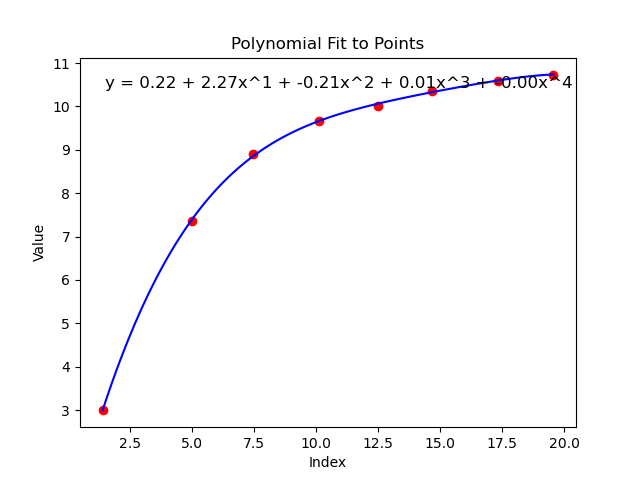

In [ ]:
polynomial = fit_polynomial(sizes_all, Pt_CNs_all, 4)
# log = fit_logarithmic(num_atoms, Pt_CNs_all)

In [ ]:
print(Pt_CNs_all)

[3.0, 6.75, 8.333333333333334, 9.1875, 9.72, 10.083333333333334, 10.346938775510203, 10.546875, 10.703703703703704, 10.83, 10.933884297520661, 11.020833333333334, 11.094674556213018, 11.158163265306122, 11.213333333333333, 11.26171875, 11.304498269896193, 11.342592592592593, 11.376731301939058]


In [ ]:
test = ClusterNeighbor()
test.load_xyz(path = "/Users/juanjuanhuang/Desktop/neighbor/structure_examples/HKUST1_updated.cif")

# test.view_xyz(show_symbol=True)
new = test.expand_cif((3,3,3))
# test.get_CN(center_atom='Pb', CN_atom="O")
test.load_xyz(from_file=False, atom_object=new)
# test.view_xyz(show_symbol=True)
# test.get_CN(center_atom='Pb', CN_atom="O")

In [ ]:
from ase.io import read
from ase.build import make_supercell
import numpy as np

def expand_structure(cif_file, repetitions):
    """
    Expand the structure from a CIF file by repeating the unit cell.
    
    Parameters:
    cif_file (str): Path to the CIF file.
    repetitions (tuple): Number of repetitions along each axis (x, y, z).
    
    Returns:
    Atoms: The expanded structure.
    """
    # Read the CIF file
    structure = read(cif_file)

    # Create the repetition matrix
    repetition_matrix = np.diag(repetitions)

    # Expand the structure
    expanded_structure = make_supercell(structure, repetition_matrix)

    return expanded_structure

# Example usage:
cif_file =  "/Users/juanjuanhuang/Desktop/neighbor/test_Pt/Ptfoil_243678.cif"
# repetitions = (2, 2, 2)  # Repeat twice along each axis
repetitions = (20, 20, 20)  # Repeat twice along each axis

expanded_structure = expand_structure(cif_file, repetitions)

# Save the expanded structure to a new CIF file
write('expanded_structure.cif', expanded_structure)

# Optional: visualize the expanded structure using ASE's viewer
expanded_structure.write('expanded_structure.xyz')
